# Compute moving averages

In this notebook we demonstrate how to compute moving averages for odd and even orders using Pandas.

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Create-Datasets" from this repo.

## Data set synopsis
The timeseries is collected between January 1992 and May 2016.

It consists of a single series of monthly values representing sales volumes. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")

# Load data

In [2]:
df = pd.read_csv("../Datasets/example_retail_sales.csv", index_col=["ds"])

In [3]:
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


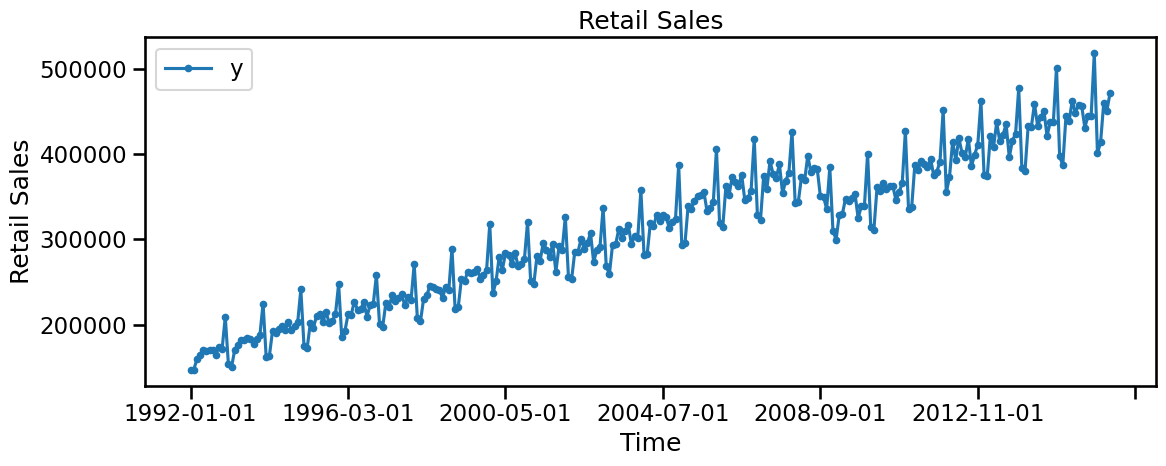

In [4]:
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(ax=ax, marker=".")
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")
ax.set_title("Retail Sales")
plt.tight_layout()

The data has a monthly frequency and we observe yearly seasonality (i.e., a pattern which repeats every 12 periods).

# Compute moving averages

In [5]:
window_size = 3  # AKA the order of the moving average
ma_3 = df.rolling(
    window=window_size,  # Size of the window
    center=True  # Compute average at center of window
    # This flag only works correctly for odd window sizes
).mean()

ma_3.rename(columns={"y": "3-MA"}, inplace=True)  # Rename the column

ma_3.head()

,3-MA
ds,
1992-01-01,NaN
1992-02-01,150930.333333
1992-03-01,156694.666667
1992-04-01,164357.666667
1992-05-01,167466.666667


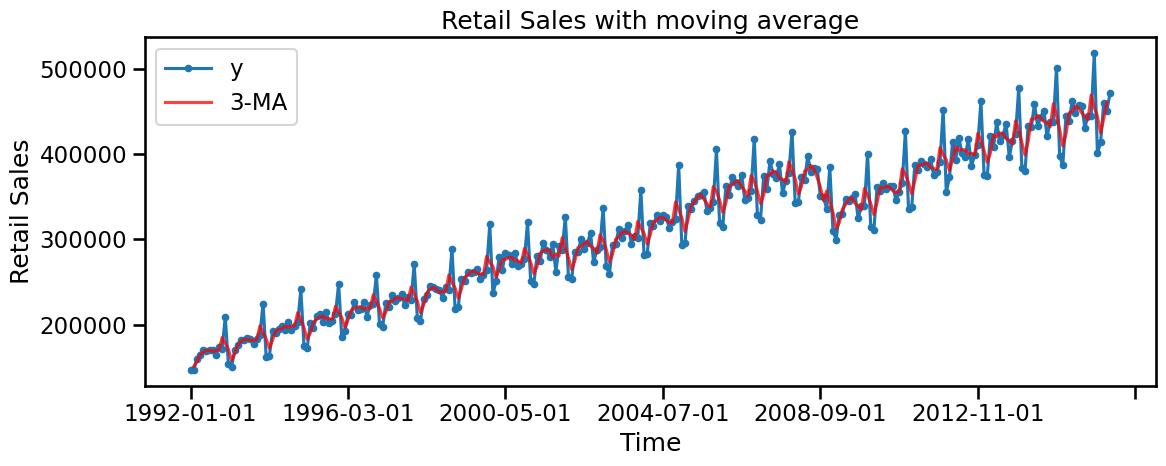

In [6]:
# Plot the result
fig, ax = plt.subplots(figsize=[12, 5])

df.plot(ax=ax, marker=".")
ma_3.plot(ax=ax, color="r", alpha=0.75)

ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")
ax.set_title("Retail Sales with moving average")
plt.tight_layout()

We can see that a moving average of order 3 smooths the data, however, is still impacted by the seasonality in the data.

Because we expect seasonality with a period of 12 we should try 2 x 12-MA.

In [7]:
# This does not give the correct answer in Pandas
df.assign(ma_4=df.rolling(window=4, center=True).mean())

,y,ma_4
ds,,
1992-01-01,146376,NaN
1992-02-01,147079,NaN
1992-03-01,159336,154115.00
1992-04-01,163669,160038.00
1992-05-01,170068,165434.00
...,...,...
2016-01-01,400928,444310.50
2016-02-01,413554,448207.00
2016-03-01,460093,431377.50


The first correct value should be:

In [8]:
(
    (1 / 8) * 146376
    + (1 / 4) * 147079
    + (1 / 4) * 159336
    + (1 / 4) * 163669
    + (1 / 8) * 170068
)

157076.5

In [9]:
# This gives the correct answer when computing the centered moving averages of moving averages
df_ = df.copy()
df_["ma_4"] = df_.rolling(window=4).mean()
df_["2xma_4"] = df_["ma_4"].rolling(window=2).mean()
df_["result"] = df_["2xma_4"].shift(-2)
df_

,y,ma_4,2xma_4,result
ds,,,,
1992-01-01,146376,NaN,NaN,NaN
1992-02-01,147079,NaN,NaN,NaN
1992-03-01,159336,NaN,NaN,157076.500
1992-04-01,163669,154115.00,NaN,162736.000
1992-05-01,170068,160038.00,157076.500,166753.250
...,...,...,...,...
2016-01-01,400928,452161.75,455910.375,446258.750
2016-02-01,413554,444310.50,448236.125,439792.250
2016-03-01,460093,448207.00,446258.750,440189.125


In [10]:
# Compute 2 X 12-MA
window_size = 12
ma_2x12 = (
    df.rolling(window=window_size)
    .mean()  # Apply the 12-MA without a centered window
    # The average is computed at the end of the window
    .rolling(window=2)
    .mean()  # Apply the 2-MA without a centred window
    # The average is computed at the end of the window
    .shift(-window_size // 2)  # Shift is required to align the 2x4-MA to what a
    # centered window would have produced
    # Integer division is used as shift() requires an int
)

ma_2x12.rename(columns={"y": "2x12-MA"}, inplace=True)  # Rename the column

ma_2x12.head(10)

,2x12-MA
ds,
1992-01-01,NaN
1992-02-01,NaN
1992-03-01,NaN
1992-04-01,NaN
1992-05-01,NaN
1992-06-01,NaN
1992-07-01,168127.041667
1992-08-01,168537.583333
1992-09-01,169125.541667


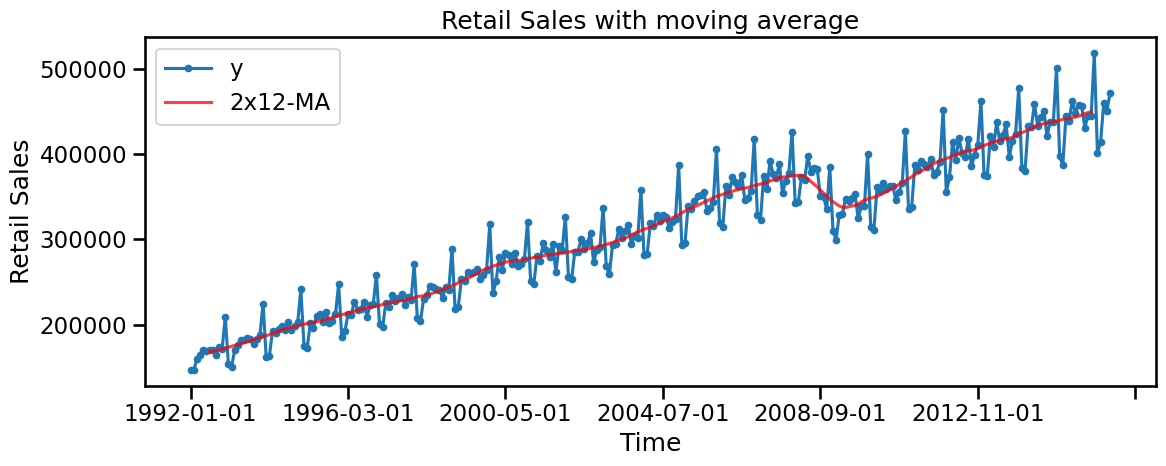

In [11]:
# Plot the result
fig, ax = plt.subplots(figsize=[12, 5])

df.plot(ax=ax, marker=".")
ma_2x12.plot(ax=ax, color="r", alpha=0.75)

ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")
ax.set_title("Retail Sales with moving average")
plt.tight_layout()

We can see that using a 2x12-MA smooths out the yearly seasonality and we observe a trend line!